In [1]:
%pip install numpy
%pip install matplotlib
%pip install fastai
%pip install accelerate
%pip install -U transformers diffusers ftfy
%pip install torch
%pip install torchvision
%pip install opencv-python
%pip install ipywidgets

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.2/232.2 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.6/67.6 kB 11.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 45.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 66.5 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 72.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.1/330.1 kB 42.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 44.3 MB/s eta 0:00:0000:01

### Setup


In [2]:
import sys
print(sys.version)

3.9.16 (main, Dec  7 2022, 01:11:51) 
[GCC 9.4.0]


In [3]:
import os

# Set CUDA_LAUNCH_BLOCKING environment variable
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [4]:
import logging
import inspect

from pathlib import Path

import cv2

import matplotlib.pyplot as plt
import numpy as np
import torch
from accelerate import Accelerator
from diffusers import (
    AutoencoderKL,
    LMSDiscreteScheduler,
    UNet2DConditionModel,
    DDIMScheduler,
    EulerDiscreteScheduler
)
from transformers import PreTrainedModel, AutoModel
from fastai.basics import show_image, show_images
from fastcore.all import concat
from fastdownload import FastDownload
from huggingface_hub import notebook_login
from PIL import Image
from torch import autocast
from torchvision import transforms as tfms
from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer, logging
from typing import Optional

In [5]:
# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
# Authenticate
path = Path.home() / ".cache" / "huggingface" / "token"
if not path.exists():
    notebook_login()

In [7]:
# Set seed
torch.manual_seed(1)

# Load the autoencoder model which will be used to decode the latents into image space.
#vae = AutoencoderKL.from_pretrained("stabilityai/stable-diffusion-2-1", subfolder="vae")
#tokenizer = CLIPTokenizer.from_pretrained("laion/CLIP-ViT-H-14-laion2B-s32B-b79K")
#text_encoder = CLIPTextModel.from_pretrained("laion/CLIP-ViT-H-14-laion2B-s32B-b79K")
#unet = UNet2DConditionModel.from_pretrained("stabilityai/stable-diffusion-2-1", subfolder="unet")
diffusion_scheduler = EulerDiscreteScheduler.from_pretrained("stabilityai/stable-diffusion-2-1", subfolder="scheduler")

vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")
scheduler = DDIMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", clip_sample=False, set_alpha_to_one=False)
diffusion_scheduler = scheduler

# To the GPU we go!
vae = vae.to(device)
text_encoder = text_encoder.to(device)
unet = unet.to(device)
vae_magic = 0.18215  # vae model trained with a scale term to get closer to unit variance

scheduler/scheduler_config.json:   0%|          | 0.00/345 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

In [8]:
# Set our models to eval mode (inference) for now. 
vae.eval()
text_encoder.eval()
unet.eval()

# No need for gradients since not training.
vae.requires_grad_(False)
text_encoder.requires_grad_(False)
unet.requires_grad_(False)

print()

In [9]:
def load_image(path: Path) -> Image.Image:
    return Image.open(path).convert("RGB")


def load_image_as_tensor(path: Path, size: int = 512, batch_dimension: bool = True) -> torch.Tensor:
    """
    Load image and convert to a resized tensor of values [-1, +1]
    """
    image = load_image(path)
    transform = tfms.Compose(
        [
            tfms.Resize(size),
            tfms.CenterCrop(size),
            tfms.ToTensor(),
        ]
    )
    transformed_image = transform(image)
    if batch_dimension:
        transformed_image = transformed_image.unsqueeze(0)

    return 2.0 * transformed_image - 1.0

In [10]:
def image2latent(im: Image.Image):
    im = tfms.ToTensor()(im).unsqueeze(0)
    with torch.no_grad():
        latent = vae.encode(im.to(device) * 2 - 1)
    return latent.latent_dist.sample() * vae_magic

In [11]:
def decode_latent(latents):
    with torch.no_grad():
        return vae.decode(latents / vae_magic).sample

In [12]:
def latents2images(latents):
    latents = latents / vae_magic
    with torch.no_grad():
        imgs = vae.decode(latents).sample
    imgs = (imgs / 2 + 0.5).clamp(0, 1)
    imgs = imgs.detach().cpu().permute(0, 2, 3, 1).numpy()
    imgs = (imgs * 255).round().astype("uint8")
    imgs = [Image.fromarray(i) for i in imgs]
    return imgs

In [13]:
def get_embedding_for_prompt(prompt: str, grad: bool = False) -> torch.Tensor:
    max_length = tokenizer.model_max_length
    tokens = tokenizer([prompt], padding="max_length", max_length=max_length, truncation=True, return_tensors="pt")
    tokens = tokens.input_ids.to(device)

    if grad:
        embedding = text_encoder(tokens)[0]
        embedding.requires_grad_(True)
    else:
        with torch.no_grad():
            embedding = text_encoder(tokens)[0]

    return embedding

In [14]:
def generate_image_from_embedding(text_embeddings, im_latents, mask=None, seed=None, guidance_scale=0.15):
    height = 512  # default height of Stable Diffusion
    width = 512  # default width of Stable Diffusion
    num_inference_steps = 30  # Number of denoising steps
    if seed is None:
        seed = torch.seed()
    generator = torch.manual_seed(seed)  # Seed generator to create the inital latent noise

    uncond = get_embedding_for_prompt("")
    text_embeddings = torch.cat([uncond, text_embeddings])

    # Prep Scheduler
    diffusion_scheduler.set_timesteps(num_inference_steps)

    # Prep latents
    if im_latents != None:
        # img2img
        start_step = 10
        noise = torch.randn_like(im_latents)
        latents = diffusion_scheduler.add_noise(im_latents, noise, timesteps=torch.tensor([diffusion_scheduler.timesteps[start_step]]))
        latents = latents.to(device).float()
    else:
        # just text prompts
        start_step = -1  # disable branching below
        latents = torch.randn((1, unet.in_channels, height // 8, width // 8))  # ,generator=generator)
        latents = latents.to(device)
        latents = latents * diffusion_scheduler.init_noise_sigma  # scale to initial amount of noise for t0

    noisy_latent = latents.clone()
    # Loop
    noise_pred = None
    for i, tm in tqdm(
        enumerate(diffusion_scheduler.timesteps), total=num_inference_steps, desc="Generating Masked Image for Prompt"
    ):
        if i > start_step:
            # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
            latent_model_input = torch.cat([latents] * 2)
            latent_model_input = diffusion_scheduler.scale_model_input(latent_model_input, tm)

            # predict the noise residual
            with torch.no_grad():
                noise_pred = unet(latent_model_input, tm, encoder_hidden_states=text_embeddings)["sample"]

            # perform guidance
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)

            u = noise_pred_uncond
            g = guidance_scale
            t = noise_pred_text

            if g > 0:
                pred_nonscaled = u + g * (t - u) / torch.norm(t - u) * torch.norm(u)
                pred = pred_nonscaled * torch.norm(u) / torch.norm(pred_nonscaled)
            else:
                pred = u

            noise_pred = pred

            # compute the previous noisy sample x_t -> x_t-1
            latents = diffusion_scheduler.step(noise_pred, tm, latents).prev_sample
            if mask is not None:
                latents = latents * mask + im_latents * (1.0 - mask)

    noise_pred = noisy_latent - latents
    return latents2images(latents)[0], noise_pred

In [15]:
@torch.no_grad()
def generate_image_from_text_embedding(
    text_embedding: torch.Tensor,
    num_inference_steps: int = 50,
    height: int = 512,
    width: int = 512,
    generator: Optional[torch.Generator] = None,
    guidance_scale: float = 7.5,
    eta: float = 0.0,
) -> Image.Image:
    do_classifier_free_guidance = guidance_scale > 1.0

    if do_classifier_free_guidance:
        uncond_prompt = ""
        uncond_tokens = tokenizer(
            uncond_prompt,
            padding="max_length",
            max_length=tokenizer.model_max_length,
            truncation=True,
            return_tensors="pt",
        )
        uncond_embedding = text_encoder(uncond_tokens.input_ids.to(device))[0]

        # duplicate unconditional embeddings for each generation per prompt, using mps friendly method
        uncond_embeddings = uncond_embedding.view(
            1,  # batch size
            uncond_embedding.shape[1],  # sequence length
            -1,
        )

        # For classifier free guidance, we need to do two forward passes.
        # Here we concatenate the unconditional and text embeddings into a single batch
        # to avoid doing two forward passes
        text_embedding = torch.cat([uncond_embeddings, text_embedding])

    latents_shape = (1, unet.config.in_channels, height // 8, width // 8)
    latents_dtype = text_embedding.dtype

    if device.type == "mps":
        # rand doesn't exist on mps
        latents = torch.randn(latents_shape, device="cpu", generator=generator, dtype=latents_dtype).to(device)
    else:
        latents = torch.randn(latents_shape, device=device, generator=generator, dtype=latents_dtype)

    diffusion_scheduler.set_timesteps(num_inference_steps)

    latents *= diffusion_scheduler.init_noise_sigma

    # prepare extra kwargs for the scheduler step, since not all schedulers have the same signature
    # eta (η) is only used with the DDIMScheduler, it will be ignored for other schedulers.
    # eta corresponds to η in DDIM paper: https://arxiv.org/abs/2010.02502
    # and should be between [0, 1]
    accepts_eta = "eta" in set(inspect.signature(diffusion_scheduler.step).parameters.keys())
    extra_step_kwargs = {}
    if accepts_eta:
        extra_step_kwargs["eta"] = eta

    progress = tqdm(enumerate(diffusion_scheduler.timesteps), total=num_inference_steps)
    progress.set_description("Generating Image from Text Embedding")

    for index, timestep in progress:
        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents
        latent_model_input = diffusion_scheduler.scale_model_input(latent_model_input, timestep)

        # predict the noise residual
        noise_pred = unet(latent_model_input, timestep, encoder_hidden_states=text_embedding)["sample"]

        # perform guidance
        if do_classifier_free_guidance:
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            
            # Option 1
            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
            
            # Option 2
#             u = noise_pred_uncond
#             g = 0.15
#             t = noise_pred_text

#             if g > 0:
#                 pred_nonscaled = u + g * (t - u) / torch.norm(t - u) * torch.norm(u)
#                 pred = pred_nonscaled * torch.norm(u) / torch.norm(pred_nonscaled)
#             else:
#                 pred = u

#             noise_pred = pred

        # compute previous noisy sample x_t -> x_t-1
        latents = diffusion_scheduler.step(noise_pred, timestep, latents, **extra_step_kwargs).prev_sample
    
    return latents2images(latents)[0]

In [16]:
prompt = "A photo of Barack Obama smiling with a big grin"
image_path = Path("..", "assets", "Official_portrait_of_Barack_Obama.jpg")

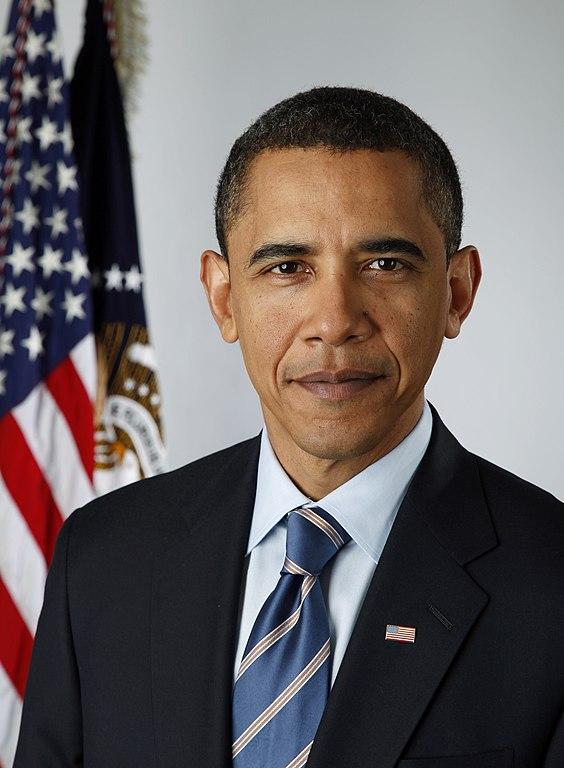

In [17]:
img = load_image(image_path)
img.show()

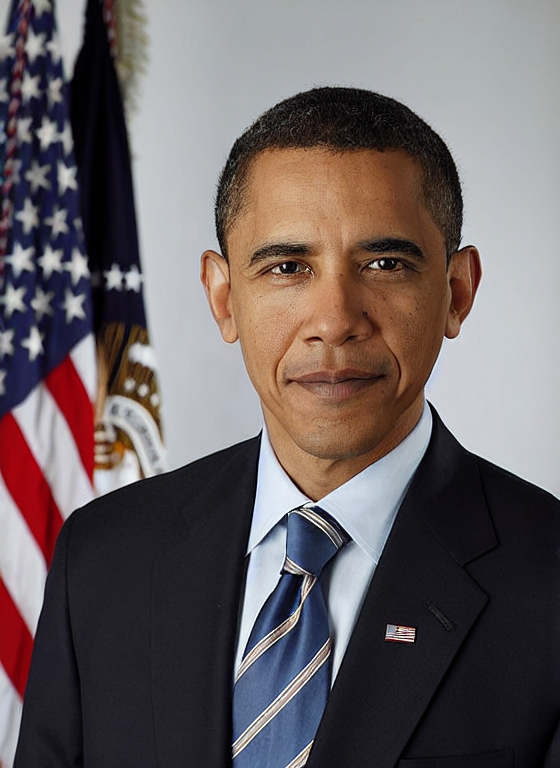

In [18]:
init_latent = image2latent(img)
latents2images(init_latent)[0].show()

In [19]:
# Initialise the text embedding for optimisation
text_embedding = get_embedding_for_prompt(prompt, grad=True)
text_embedding = torch.nn.Parameter(text_embedding)
text_embedding = text_embedding.detach()
text_embedding.requires_grad_()

tensor([[[-0.3884,  0.0229, -0.0522,  ..., -0.4899, -0.3066,  0.0675],
         [ 0.0290, -1.3258,  0.3085,  ..., -0.5257,  0.9768,  0.6652],
         [ 1.1565,  0.1318,  0.7895,  ..., -2.1024, -1.1519, -0.3311],
         ...,
         [-1.5818,  1.6135, -0.5790,  ..., -0.8666, -0.3756, -0.1186],
         [-1.5888,  1.6309, -0.5721,  ..., -0.8332, -0.3878, -0.1382],
         [-1.5733,  1.6212, -0.5568,  ..., -0.8416, -0.4058, -0.2069]]],
       device='cuda:0', requires_grad=True)

In [20]:
og_embedding = text_embedding.clone()


/tmp/ipykernel_32/3783863565.py:25: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((1, unet.in_channels, height // 8, width // 8))  # ,generator=generator)


Generating Masked Image for Prompt:   0%|          | 0/30 [00:00<?, ?it/s]

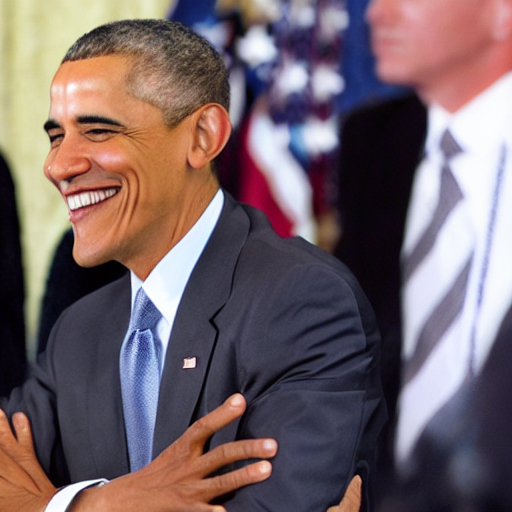

In [21]:
img, _ = generate_image_from_embedding(og_embedding, None)
img.show()

  0%|          | 0/50 [00:00<?, ?it/s]

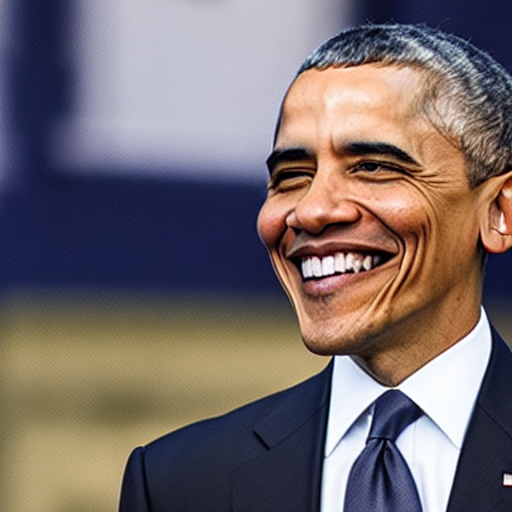

In [22]:
generator = torch.Generator("cuda").manual_seed(0)

img = generate_image_from_text_embedding(og_embedding)
img.show()

In [23]:
def preprocess(image):
    w, h = image.size
    w, h = map(lambda x: x - x % 32, (w, h))  # resize to integer multiple of 32
    image = image.resize((w, h), resample=Image.LANCZOS)
    image = np.array(image).astype(np.float32) / 255.0
    image = image[None].transpose(0, 3, 1, 2)
    image = torch.from_numpy(image)
    return 2.0 * image - 1.0

In [24]:
init_image = load_image(image_path)
init_latent = image2latent(init_image)

In [25]:
init_image_tensor = load_image_as_tensor(image_path).to(device)
init_image_latent_dist = vae.encode(init_image_tensor).latent_dist
init_image_latent = init_image_latent_dist.sample() * vae_magic

In [26]:
import torch.optim as optim

# Define learning rate and number of iterations
lr = 2e-3
it = 1000

# Initialize the optimizer for updating the embedding
opt = optim.Adam(
    [text_embedding],  # only optimise the embedding
    lr=lr,
)

# Define the loss criterion
criteria = torch.nn.MSELoss()

# Initialize a list to store the loss history
history = []

# Create a progress bar
progress = tqdm(range(it))
progress.set_description("steps")

scheduler.set_timesteps(1000) # reset

  0%|          | 0/1000 [00:00<?, ?it/s]

In [27]:

accelerator = Accelerator(
    gradient_accumulation_steps=1,
    mixed_precision="fp16",
)
if accelerator.is_main_process:
    accelerator.init_trackers(
        "imagic",
        config={
            "embedding_learning_rate": lr,
            "text_embedding_optimization_steps": it,
        },
    )



In [28]:
print("First optimizing the text embedding to better reconstruct the init image")
torch.autograd.set_detect_anomaly(True)

First optimizing the text embedding to better reconstruct the init image


In [29]:
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = "max_split_size_mb:128"
opt.zero_grad()

In [30]:
for _ in progress:
    with accelerator.accumulate(text_embedding):
        noise = torch.randn_like(init_image_latent).to(device)
        timesteps = torch.randint(1000, (1,), device=device)

        noisy_latent = scheduler.add_noise(init_image_latent, noise, timesteps=timesteps)

        noise_pred = unet(noisy_latent, timesteps, text_embedding).sample

        loss = criteria(noise_pred, noise)
        accelerator.backward(loss)

        opt.step()
        opt.zero_grad()
    
    if accelerator.sync_gradients:
        # Checks if the accelerator has performed an optimization step behind the scenes
        progress.update(1)
    
    progress.set_postfix({"loss": loss.item()})

accelerator.wait_for_everyone()
    

/tmp/ipykernel_32/3783863565.py:25: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((1, unet.in_channels, height // 8, width // 8))  # ,generator=generator)


Generating Masked Image for Prompt:   0%|          | 0/30 [00:00<?, ?it/s]

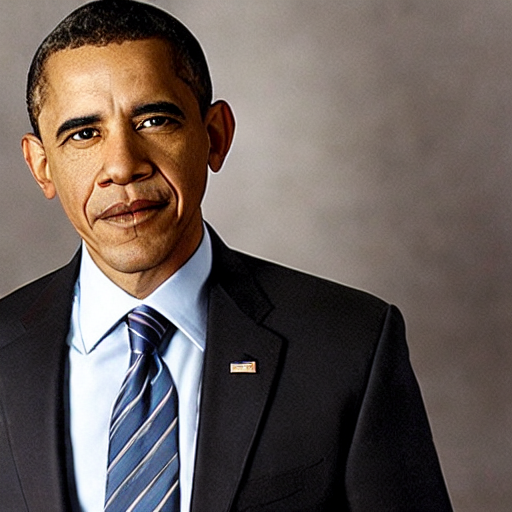

In [31]:
img, noise_pred = generate_image_from_embedding(text_embedding, None)
img.show()

## Step 2. Fine Tune the Model

In [32]:
text_embedding.requires_grad_(False) # fix the text embedding

lr = 5e-7
it = 1500

unet.requires_grad_(True)
unet.train()
opt = optim.Adam(
    unet.parameters(),  # optimise unet parameters
    lr=lr,
)
criteria = torch.nn.MSELoss()

scheduler.set_timesteps(1000) # reset

In [33]:
progress = tqdm(range(it))
for _ in progress:
    with accelerator.accumulate(unet.parameters()):
        noise = torch.randn_like(init_image_latent).to(device)
        timesteps = torch.randint(1000, (1,), device=device)
        noisy_latent = scheduler.add_noise(init_image_latent, noise, timesteps)

        noise_pred = unet(noisy_latent, timesteps, text_embedding).sample

        loss = criteria(noise_pred, noise)
        accelerator.backward(loss)

        

        opt.step()
        opt.zero_grad()
    
    if accelerator.sync_gradients:
        # Checks if the accelerator has performed an optimization step behind the scenes
        progress.update(1)
    
    progress.set_postfix({"loss": loss.item()})

accelerator.wait_for_everyone()

  0%|          | 0/1500 [00:00<?, ?it/s]

## 3. Interpolate between the embeddings

Generating Masked Image for Prompt:   0%|          | 0/30 [00:00<?, ?it/s]

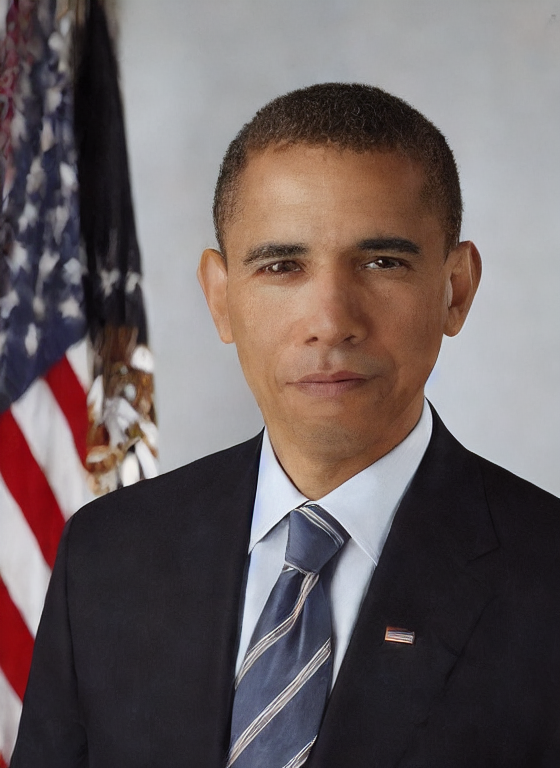

Generating Masked Image for Prompt:   0%|          | 0/30 [00:00<?, ?it/s]

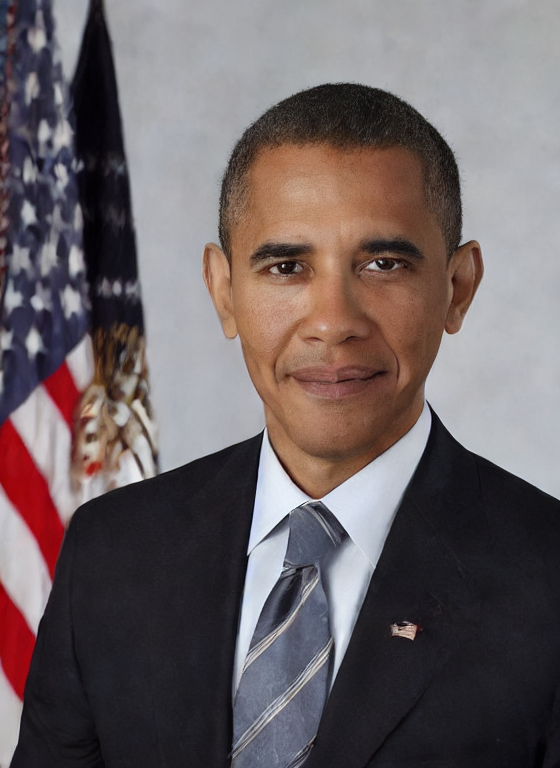

Generating Masked Image for Prompt:   0%|          | 0/30 [00:00<?, ?it/s]

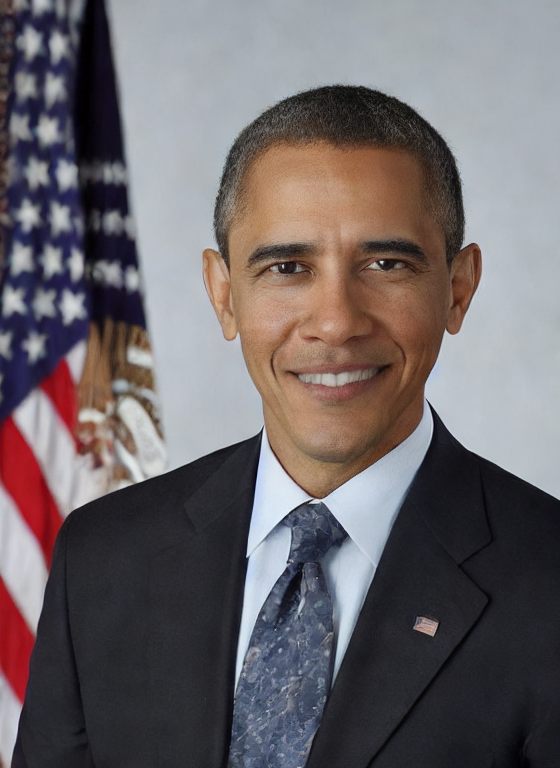

Generating Masked Image for Prompt:   0%|          | 0/30 [00:00<?, ?it/s]

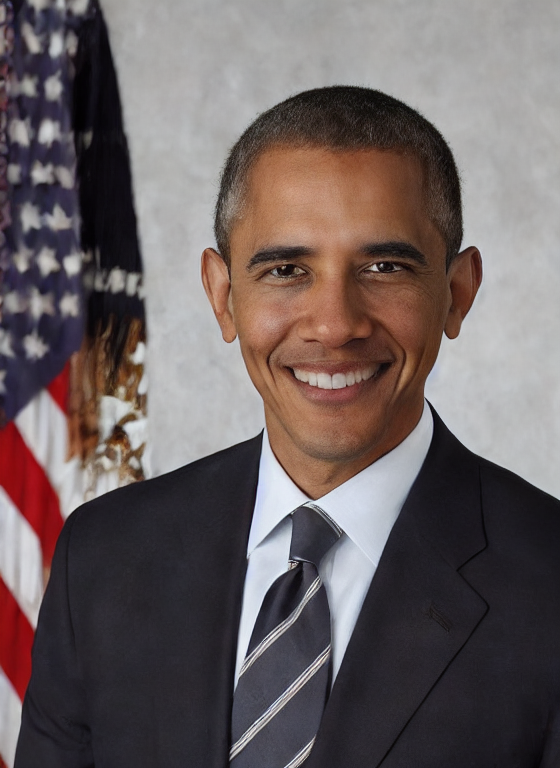

Generating Masked Image for Prompt:   0%|          | 0/30 [00:00<?, ?it/s]

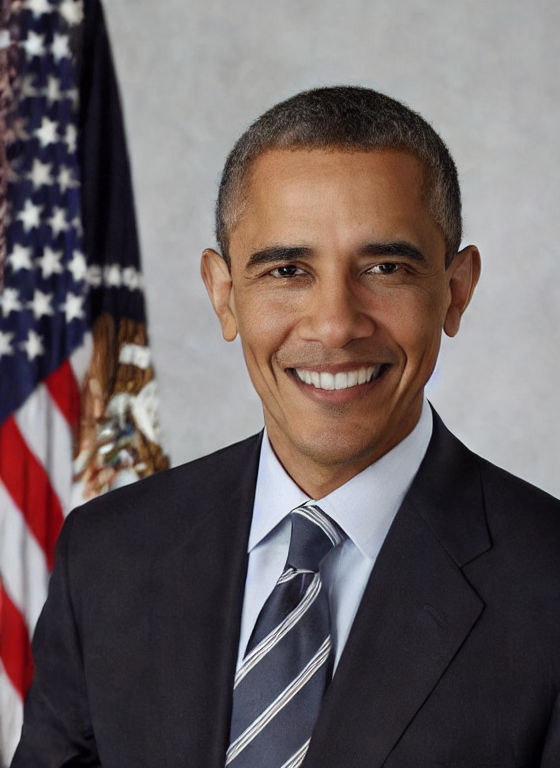

In [34]:
for alpha in (0.0, 0.5, 0.75, 1, 1.25):
    new_emb = alpha*og_embedding + (1-alpha)*text_embedding
    img, _ = generate_image_from_embedding(new_emb, init_latent)
    img.show()

## Save model and embeddings

In [35]:
# Save trained unet
torch.save(unet, '../saved/unet.pth')
torch.save(unet.state_dict(), '../saved/unit_state_dict.pth')

# Save the embeddings
torch.save(og_embedding, '../saved/og_embedding.pth')
torch.save(text_embedding, '../saved/text_embedding.pth')


In [36]:
# Load
og_embedding = torch.load("../saved/og_embedding.pth", map_location=device)
text_embedding = torch.load("../saved/text_embedding.pth", map_location=device)